# Text Classifier 

Ce notebook est divisé en deux parties, la première porte sur de la classification de texte sur un dataset prévu à cet effet par scikit-learn, 20newsgroups. La seconde sur la classification de tickets de supports récupérés chez Microsoft.  
La première partie sert à mettre en évidence les différentes étapes du traitement de données pour la classification de texte. La seconde vise à appliquer ces méthodes à des données réelles et comparer les différentes approches.

## 20newsgroups Dataset - Démonstration de classification
### Loading the Dataset

In [1]:
# Import des bibliothèques utiles pour la première partie du notebook.
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# On charge uniquement les données d'entrainement pour le moment
twenty_train = fetch_20newsgroups(subset = 'train', shuffle = True) 

In [2]:
# Afficher les catégories
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
# Afficher la première ligne des 3 premiers fichiers
for i in range(3):
    print(f'\nLine {i}')
    print('\n'.join(twenty_train.data[i].split('\n')[:3]))


Line 0
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu

Line 1
From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports

Line 2
From: twillis@ec.ecn.purdue.edu (Thomas E Willis)
Subject: PB questions...
Organization: Purdue University Engineering Computer Network


### Extracting features from text files

Using Bag of Word technique to create de dictionnary of the words present in our files and then vectorize our text.

In [4]:
count_vect = CountVectorizer()
# Crée le dictionnaire et retourne une matrice Document - Terme
X_train_counts = count_vect.fit_transform(twenty_train.data)
print(X_train_counts.shape)

(11314, 130107)


La matrice est donc de taille (nombre_documents, nombre_features).  
Par ailleurs, de cette façon, les longs documents ont plus de poids que les courts. Les mots fréquents comme "the", "is"... devraient aussi avoir un poids réduit.  
Cela s'appelle TF-IDF : Term Frequency times Inverse Document Frequency.

In [5]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 130107)

### Naive Bayes

In [6]:
# Utiliser Naive Bayes pour classer les fichiers
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [7]:
# Même chose mais avec une pipeline (moins de code)
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

### Mesurer la précision 

In [8]:
twenty_test = fetch_20newsgroups(subset = 'test', shuffle = True)
predicted = text_clf.predict(twenty_test.data)
print(f'Accuracy: {np.mean(predicted == twenty_test.target)}')

Accuracy: 0.7738980350504514


### Support Vector Machines (SVM)

In [9]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss = 'hinge', penalty = 'l2',
                                                  alpha = 1e-3, random_state = 42)),
                        ])

In [10]:
_ = text_clf_svm.fit(twenty_train.data, twenty_train.target)

### Mesurer la précision 

In [11]:
predicted_svm = text_clf_svm.predict(twenty_test.data)
print(f'Accuracy: {np.mean(predicted_svm == twenty_test.target)}')

Accuracy: 0.8240839086563994


### Grid Search

### ... on Naive Bayes

In [12]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # Unigrammes et Bigrammes
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
             }

In [13]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs = -1)
gs_clf = gs_clf.fit(twenty_train.data, twenty_train.target)

In [14]:
print(f'Best Score: {gs_clf.best_score_}')
print(f'Best Params: {gs_clf.best_params_}')

Best Score: 0.9157684864695698
Best Params: {'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [15]:
predicted_gs = gs_clf.predict(twenty_test.data)
print(f'Accuracy: {np.mean(predicted_gs == twenty_test.target)}')

Accuracy: 0.8361656930430165


### ... on SVM

In [16]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], # Unigrammes et Bigrammes
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3),
                 }

In [17]:
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs = -1)
gs_clf_svm = gs_clf_svm.fit(twenty_train.data, twenty_train.target)

In [18]:
print(f'Best Score: {gs_clf_svm.best_score_}')
print(f'Best Params: {gs_clf_svm.best_params_}')

Best Score: 0.9051618841994754
Best Params: {'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [19]:
predicted_svm_gs = gs_clf_svm.predict(twenty_test.data)
print(f'Accuracy: {np.mean(predicted_svm_gs == twenty_test.target)}')

Accuracy: 0.8351035581518853


### Enlever les Stopwords

Les Stopwords (ou mots vides) sont les mots communs qui ne sont pas très significatifs comme "le", "la" en français et "the", "then", "a" en anglais.  
Ces mots peuvent parasiter l'apprentissage de la machine et il peut donc être avantageux de les enlever.

In [20]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
                    ])

In [21]:
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

In [22]:
twenty_test = fetch_20newsgroups(subset = 'test', shuffle = True)
predicted = text_clf.predict(twenty_test.data)
print(f'Accuracy: {np.mean(predicted == twenty_test.target)}')

Accuracy: 0.8169144981412639


On peut voir qu'en enlevant les stopwords, la justesse du modèle Naive Bayes passe de 77 % à 81 %.

## Microsoft's support tickets

### Importing libraries

In [23]:
# Manipulation de données, calcul et visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pré traitement des données
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# Modèles
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Réseau de neurones
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

# Métriques
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, plot_confusion_matrix


### Loading Dataset

In [24]:
df = pd.read_csv('all_tickets.csv')
df.head(3)

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4


### Data Exploration

In [25]:
print(df.shape)

(48549, 9)


On a 48 549 lignes pour 9 colonnes.

In [26]:
print(df.dtypes)

title               object
body                object
ticket_type          int64
category             int64
sub_category1        int64
sub_category2        int64
business_service     int64
urgency              int64
impact               int64
dtype: object


Toutes les variables sont des nombres entiers (int) à part title et body qui sont des "object", ce devraient être des string mais cela signifie qu'il y a certainement des valeurs manquantes NaN (Not a Number) comme on peut le voir pour la première valeur de title.

In [27]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 3.3+ MB
None


In [28]:
df.nunique(axis = 0)

title               30118
body                48549
ticket_type             2
category               13
sub_category1          59
sub_category2         115
business_service      103
urgency                 4
impact                  5
dtype: int64

On a 2 types de tickets, 13 catégories, 59 sous-catégories et 115 sous-catégories de niveau 2, 4 niveau d'urgence et 5 catégories d'impact.  
On remarque que l'on n'a pas de message dupliqué mais qu'il manque des titres.

In [29]:
print('Nombre de tickets manquants :')
print(len(df[df['body'].isnull() == True]))

Nombre de tickets manquants :
0


In [30]:
print('Nombre de titres manquants :')
print(len(df[df['title'].isnull() == True]))

Nombre de titres manquants :
712


In [31]:
print(df['ticket_type'].value_counts())

1    34621
0    13928
Name: ticket_type, dtype: int64


On peut voir que la distribution entre les deux types de tickets n'est pas équilibrée.

In [32]:
print(df['category'].value_counts())

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64


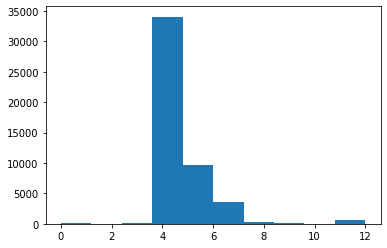

In [33]:
plt.hist(df['category'])
plt.show()

La distribution entre les catégories est disparate également. On a principalement des tickets de catégories 4, 5 et 6.

In [34]:
print(df['urgency'].value_counts())

3    34621
1     6748
2     5528
0     1652
Name: urgency, dtype: int64


Idem pour les urgences.

In [35]:
print(df['impact'].value_counts())

4    34621
3    13184
0      471
2      228
1       45
Name: impact, dtype: int64


Idem pour les impacts.

### Data Pre Processing

On isole les catégories cibles dans un dataframe.

In [36]:
y = pd.DataFrame(df['category'])
y.head(3)

,category
0,4
1,6
2,5


Idem pour le contenu des tickets. Ce sont les messages des utilisateurs sur lesquels on va baser notre prédiction.

In [37]:
X = pd.DataFrame(df['body'])
X.head(3)

,body
0,hi since recruiter lead permission approve req...
1,icon dear please setup icon per icon engineers...
2,work experience user hi work experience studen...


On sépare les données en jeux d'entraînement et de test.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X['body'], y, 
                                   test_size=0.4, 
                                   random_state=42)

In [39]:
print(f'X Shape: {X_train.shape}')
print(f'y Shape: {y_train.shape}')

X Shape: (29129,)
y Shape: (29129, 1)


On vectorise les textes.

In [40]:
cv = CountVectorizer()
X_train_tf = cv.fit_transform(X_train)
X_train_tf.shape

(29129, 10739)

On applique "term-frequency times inverse document-frequency" pour normaliser la matrice de mot. De cette façon le modèle ne sera pas biaisé par les mots très fréquents ou les documents anormalement longs.

In [41]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf= tfidf_transformer.fit_transform(X_train_tf)
X_train_tfidf.shape

(29129, 10739)

### Modèle

#### Multinomial Naive Bayes

L'algorithme Multinomial Naive Bayes s'applique lorsque les vecteurs représentent la fréquence d'apparition d'un terme pour pouvoir labéliser ces vecteurs. C'est notre cas.

In [42]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

C:\Users\Juliette\Documents\SPIE\Classifier\.env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()

In [43]:
X_test_tf = cv.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_tf)
pred = mnb.predict(X_test_tfidf)

In [44]:
pred_auc = to_categorical(np.asarray(pred), num_classes=13)

In [45]:
print(f'F1 Score : {(f1_score(y_test, pred, average = "weighted"))}')
print(f"Test auc : {roc_auc_score(y_test, pred_auc, multi_class='ovr')}")
print(f'Accuracy : {(accuracy_score(y_test, pred))}')

F1 Score : 0.7562278308365803
Test auc : 0.545313834109828
Accuracy : 0.8038105046343975


#### GridSearch sur MultinomialNB

Cette fois-ci on enlève les Stopwords.

In [46]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words = 'english', ngram_range = (1,2))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

In [47]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], # Unigrammes et Bigrammes
              'clf__alpha': (1e-2, 1e-3),
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs = -1)
gs_clf = gs_clf.fit(X_train, y_train)

print(f'Best Score: {gs_clf.best_score_}')
print(f'Best Params: {gs_clf.best_params_}')

predicted_gs = gs_clf.predict(X_test)

C:\Users\Juliette\Documents\SPIE\Classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Juliette\Documents\SPIE\Classifier\.env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Best Score: 0.8477119321555436
Best Params: {'clf__alpha': 0.01, 'vect__ngram_range': (1, 2)}


In [48]:
print(f'F1 Score: {f1_score(y_test["category"], predicted_gs, average = "weighted")}')
pred_auc = to_categorical(np.asarray(predicted_gs), num_classes=13)
print(f"Test auc : {roc_auc_score(y_test, pred_auc, multi_class='ovr')}")
print(f'Accuracy : {np.mean(predicted_gs == y_test["category"])}')

F1 Score: 0.8364651567419628
Test auc : 0.6562449862626472
Accuracy : 0.8465499485066942


Cette fois-ci l'accuracy et le F1 sont meilleurs ce qui signifie que Recall et Precision sont également meilleurs.

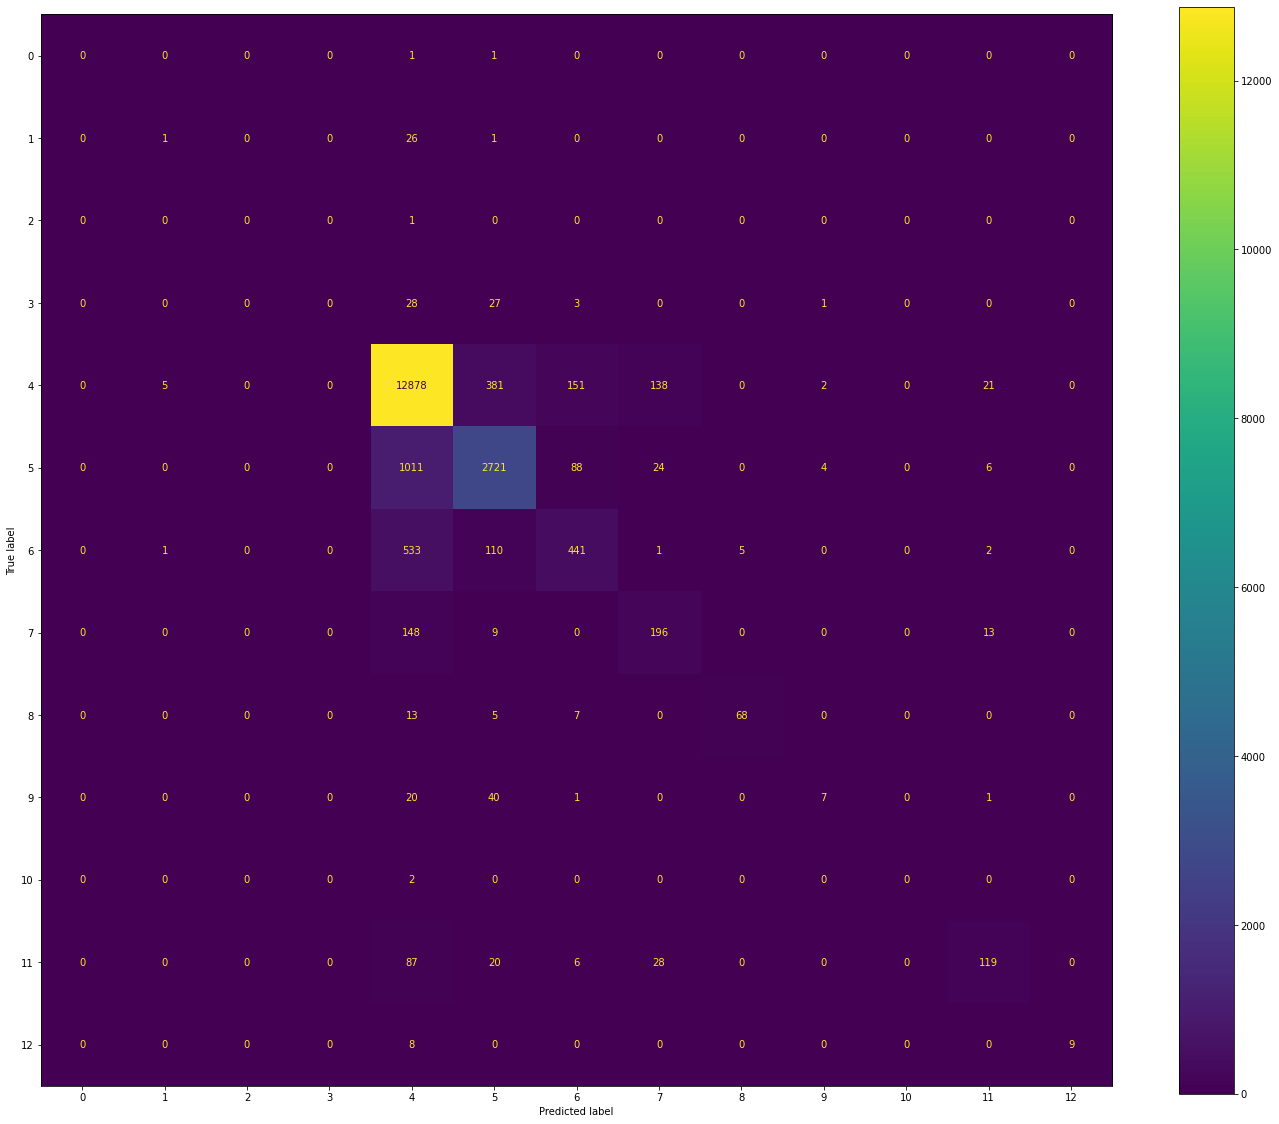

In [49]:
fig, ax = plt.subplots(figsize=(24, 20))
plot_confusion_matrix(gs_clf, X_test, y_test, ax = ax)
plt.show()

Même si l'accuracy est de 84 %, on peut voir avec la matrice de confusion qu'il y a des erreurs de catégorisation, notamment avec la classe 4 qui est bien plus peuplée que les autres.   
Le Score F1 (qui est une fonction de Precision et Recall) reste par ailleurs bon. 

#### SVM

In [50]:
tickets_clf_svm = Pipeline([('vect', CountVectorizer(stop_words = 'english', ngram_range = (1,2))),
                        ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss = 'hinge', penalty = 'l2',
                                                  alpha = 1e-3, random_state = 42)),
                        ])

In [51]:
tickets_clf_svm.fit(X_train, y_train)

C:\Users\Juliette\Documents\SPIE\Classifier\.env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf-svm', SGDClassifier(alpha=0.001, random_state=42))])

In [52]:
pred_svm = tickets_clf_svm.predict(X_test)
pred_auc = to_categorical(np.asarray(pred_svm), num_classes=13)
print(f"Test auc : {roc_auc_score(y_test, pred_auc, multi_class='ovr')}")
print(f'F1 Score: {(f1_score(y_test, pred_svm, average = "weighted"))}')
print(f'Accuracy: {(accuracy_score(y_test, pred_svm))}')

Test auc : 0.5382778327099887
F1 Score: 0.6880660497028366
Accuracy: 0.7579814624098867


Svm est moins performant que MultibinomialNB.

#### GridSearch sur SVM

In [53]:
parameters_svm = {'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3),
                 }

gs_clf_svm = GridSearchCV(tickets_clf_svm, parameters_svm, n_jobs = -1)
gs_clf_svm = gs_clf_svm.fit(X_train, y_train)

print(f'Best Score: {gs_clf_svm.best_score_}')
print(f'Best Params: {gs_clf_svm.best_params_}')

predicted_svm_gs = gs_clf_svm.predict(X_test)

C:\Users\Juliette\Documents\SPIE\Classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\Juliette\Documents\SPIE\Classifier\.env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Best Score: 0.781557906027295
Best Params: {'clf-svm__alpha': 0.001, 'tfidf__use_idf': False}


In [54]:
print(f'F1 Score: {(f1_score(y_test, predicted_svm_gs, average = "weighted"))}')
pred_auc = to_categorical(np.asarray(predicted_svm_gs), num_classes=13)
print(f"Test auc : {roc_auc_score(y_test, pred_auc, multi_class='ovr')}")
print(f'Accuracy: {np.mean(predicted_svm_gs == y_test["category"])}')

F1 Score: 0.7096302911499649
Test auc : 0.5444418666921483
Accuracy: 0.7716786817713697


#### Réseau de neurones

In [55]:
MAX_NB_WORDS = 20000

X_train = X_train.astype(str)
X_test = X_test.astype(str)

# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print(f'{len(word_index)} mots différents.')

10739 mots différents.


In [56]:
sequences[0]

[36,
 78,
 35,
 6,
 35,
 66,
 320,
 4148,
 1598,
 2991,
 876,
 528,
 1896,
 733,
 653,
 2750,
 53,
 908,
 3158,
 2992,
 2577,
 1,
 32,
 30,
 530,
 45,
 27]

Le tokenizer stocke une correspondance (mapping) entre les chaînes de mots et les identifiants des tokens. On peut ainsi reconstruire le message original.

In [57]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 10739)

In [58]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [59]:
" ".join([index_to_word[i] for i in sequences[0]])

'october cannot change hello change work keep noticing meet length requirements believe privacy policy least characters number special character upper letter please let issue cheers senior engineer'

In [60]:
X_train.head(1)

27783    october cannot change hello change work keep n...
Name: body, dtype: object

In [61]:
seq_lens = [len(s) for s in sequences]
print(f"Taille minimale de message : {min(seq_lens)}")
print(f"Taille moyenne de message : {np.mean(seq_lens)}")
print(f"Taille maximale de message : {max(seq_lens)}")

Taille minimale de message : 1
Taille moyenne de message : 39.865632187854025
Taille maximale de message : 952


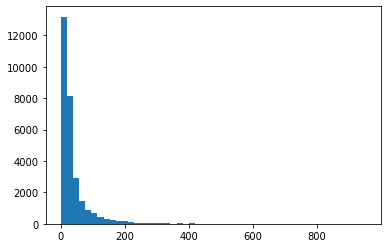

In [62]:
plt.hist(seq_lens, bins=50)

La majorité des tickets a l'air de faire moins de 200 mots.

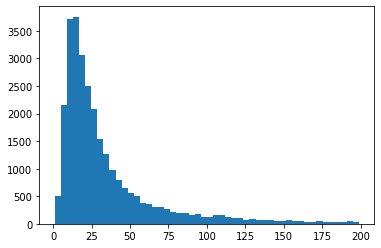

In [63]:
plt.hist([l for l in seq_lens if l < 200], bins=50)

Par soucis d'uniformisation, on ramène toutes les séquences à la même longueur.

In [64]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print(f'Shape du data train tensor : {x_train.shape}')
print(f'Shape du data test tensor : {x_test.shape}')

Shape du data train tensor : (29129, 150)
Shape du data test tensor : (19420, 150)


In [65]:
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))
print(f'Shape du label tensor : {y_train.shape}')

Shape du label tensor : (29129, 13)


In [66]:
EMBEDDING_DIM = 50
N_CLASSES = df['category'].nunique()

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [67]:
model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=128)

Epoch 1/20
205/205 [==============================] - 33s 31ms/step - loss: 2.0719 - acc: 0.6576 - val_loss: 0.9542 - val_acc: 0.7144
Epoch 2/20
205/205 [==============================] - 6s 27ms/step - loss: 0.9496 - acc: 0.7045 - val_loss: 0.8852 - val_acc: 0.7147
Epoch 3/20
205/205 [==============================] - 6s 27ms/step - loss: 0.8923 - acc: 0.7042 - val_loss: 0.8421 - val_acc: 0.7158
Epoch 4/20
205/205 [==============================] - 6s 28ms/step - loss: 0.8630 - acc: 0.7089 - val_loss: 0.8002 - val_acc: 0.7381
Epoch 5/20
205/205 [==============================] - 6s 28ms/step - loss: 0.8253 - acc: 0.7285 - val_loss: 0.7597 - val_acc: 0.7470
Epoch 6/20
205/205 [==============================] - 5s 26ms/step - loss: 0.7662 - acc: 0.7417 - val_loss: 0.7262 - val_acc: 0.7556
Epoch 7/20
205/205 [==============================] - 6s 28ms/step - loss: 0.7251 - acc: 0.7577 - val_loss: 0.6980 - val_acc: 0.7683
Epoch 8/20
205/205 [==============================] - 6s 27ms/step -

In [68]:
output_test = model.predict(x_test)
loss, acc = model.evaluate(x_test, y_test)
print(f'Test accuracy : {acc}')
print(f"Test auc : {roc_auc_score(y_test, output_test, multi_class='ovr')}")

607/607 [==============================] - 2s 4ms/step - loss: 0.5695 - acc: 0.8236
Test accuracy : 0.8235839605331421
Test auc : 0.7622822361908159


#### LSTM

In [69]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [70]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=2, batch_size=128)

Epoch 1/2
205/205 [==============================] - 316s 1s/step - loss: 0.7920 - acc: 0.7844 - val_loss: 0.5276 - val_acc: 0.8390
Epoch 2/2
205/205 [==============================] - 185s 902ms/step - loss: 0.4186 - acc: 0.8664 - val_loss: 0.4942 - val_acc: 0.8314


In [71]:
output_test = model.predict(x_test)
loss, acc = model.evaluate(x_test, y_test)
print(f'Test accuracy : {acc}')
print(f"Test auc: {roc_auc_score(y_test, output_test, multi_class='ovr')}")

607/607 [==============================] - 38s 63ms/step - loss: 0.4985 - acc: 0.8363
Test accuracy : 0.8362512588500977
Test auc: 0.8018389702630855


#### CNN-LSTM

In [72]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.2)(x)
x = LSTM(64)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [73]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=15, batch_size=128)

Epoch 1/15
205/205 [==============================] - 32s 103ms/step - loss: 0.8605 - acc: 0.7698 - val_loss: 0.5064 - val_acc: 0.8345
Epoch 2/15
205/205 [==============================] - 19s 92ms/step - loss: 0.4458 - acc: 0.8610 - val_loss: 0.4966 - val_acc: 0.8363
Epoch 3/15
205/205 [==============================] - 21s 101ms/step - loss: 0.4071 - acc: 0.8680 - val_loss: 0.4832 - val_acc: 0.8404
Epoch 4/15
205/205 [==============================] - 18s 89ms/step - loss: 0.3833 - acc: 0.8774 - val_loss: 0.4738 - val_acc: 0.8397
Epoch 5/15
205/205 [==============================] - 18s 86ms/step - loss: 0.3610 - acc: 0.8821 - val_loss: 0.4761 - val_acc: 0.8393
Epoch 6/15
205/205 [==============================] - 18s 90ms/step - loss: 0.3579 - acc: 0.8847 - val_loss: 0.4851 - val_acc: 0.8369
Epoch 7/15
205/205 [==============================] - 19s 93ms/step - loss: 0.3307 - acc: 0.8919 - val_loss: 0.4888 - val_acc: 0.8383
Epoch 8/15
205/205 [==============================] - 21s 10

In [74]:
output_test = model.predict(x_test)
loss, acc = model.evaluate(x_test, y_test)
print(f'Test accuracy : {acc}')
print(f"Test auc : {roc_auc_score(y_test, output_test, multi_class='ovr')}")

607/607 [==============================] - 8s 13ms/step - loss: 0.6189 - acc: 0.8256
Test accuracy : 0.8256436586380005
Test auc : 0.8078132981185093
